In [1]:
import pandas as pd
import numpy as np
import BGC #library which contains the majority of functions, abstractions, and helper methods for our Bipartite Graph Consensus Function
import math
import tables
import copy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import f1_score
from statsmodels.multivariate.manova import MANOVA
import warnings
import Cluster_Ensembles as CE
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Global Variable Initialization

In [2]:
#Intial Import and processing of the Cassini Dataset
df = pd.read_csv('cassini.csv') 
df = df.drop(df.columns[0], axis = 1)
X = df.to_numpy()
y = X[:,-1]
y = y - 1
y=y.astype(int)
X = X[:,0:X.shape[1]-1]

In [3]:
n_clusters = [2,3,4,5,6,7,8,9,10]
kmeans_initial_center_list = []
for k in n_clusters:
    np.random.seed(321)
    idx = np.random.randint(X.shape[0], size=k)
    initial_centers = []
    for i in idx:
        initial_centers.append(X[i])
    initial_centers = np.array(initial_centers)
    #np.savetxt("initial_centers.csv", initial_centers, delimiter=",")
    kmeans_initial_center_list.append(initial_centers)

In [4]:
partition_list_test = [] #partition list representation accepted by the EMD algorithm
mcla_alt = np.array([]).astype(int) #alternate representation of the cassini dataset in the format accepted by the mcla algorithm
for initial_centers in kmeans_initial_center_list:
    kmeans = KMeans(n_clusters=initial_centers.shape[0], init=initial_centers).fit(X)
    # Create a set of labels to get the list of clusters. Label <==> cluster.
    kmeans_labels_set = set(kmeans.labels_)
    # In following two dictionaries, each dictionary entry represents a clusters.
    kmeans_clusters = {}
    kmeans_indicator = {}
    # Iterate over all clusters to initialize the dictionaries
    for e in kmeans_labels_set: 
        # List corresponding to each dictionary key contains datapoints belonging to that cluster
        kmeans_clusters[e] = [] # Initialize the list to be empty
        # Numpy vector corresponding to each dictionary key is the indicator vector 
        # representing which datapoint belongs to that cluster
        kmeans_indicator[e] = np.zeros( (len(kmeans.labels_),1) ) # Intialize the vector to be all zero
    # Iterate over all datapoints and populate the dictionaries accordingly
    for i in range( len(kmeans.labels_) ):
        # Append to the list of datapoint of corresponding cluster
        kmeans_clusters[kmeans.labels_[i]].append(i)
        # Assign 1 to corresponding entries of corresponding vector
        kmeans_indicator[kmeans.labels_[i]][i] = 1.0
    # Append a tuple with the dictionaries to the list of partitions
    if(np.size(mcla_alt)==0):
        mcla_alt=np.asarray(BGC.output_to_array(kmeans_clusters, X.shape[0])).astype(int)
    else:
        mcla_alt=np.vstack((mcla_alt, np.asarray(BGC.output_to_array(kmeans_clusters, X.shape[0]))))
    partition_list_test.append( (kmeans_clusters, kmeans_indicator) )
    
test=partition_list_test[1]

# Testing Environment: Function Definitions

In [5]:
def generate_partitions(k_nums, data, centers=[], give_centers=False, seed=321):
    #Generating seeded center values
    if(len(centers)==0):
        kmeans_initial_center_list = []
        for k in k_nums:
            np.random.seed(seed)
            idx = np.random.randint(data.shape[0], size=k)
            initial_centers = []
            for i in idx:
                initial_centers.append(data[i])
            initial_centers = np.array(initial_centers)
            #np.savetxt("initial_centers.csv", initial_centers, delimiter=",")
            kmeans_initial_center_list.append(initial_centers)
    else:
        kmeans_initial_center_list = centers
        
    partition_list_test = [] #partition list representation accepted by the EMD algorithm
    for initial_centers in kmeans_initial_center_list:
        kmeans = KMeans(n_clusters=initial_centers.shape[0], init=initial_centers).fit(data)
        # Create a set of labels to get the list of clusters. Label <==> cluster.
        kmeans_labels_set = set(kmeans.labels_)
        # In following two dictionaries, each dictionary entry represents a clusters.
        kmeans_clusters = {}
        kmeans_indicator = {}
        # Iterate over all clusters to initialize the dictionaries
        for e in kmeans_labels_set: 
            # List corresponding to each dictionary key contains datapoints belonging to that cluster
            kmeans_clusters[e] = [] # Initialize the list to be empty
            # Numpy vector corresponding to each dictionary key is the indicator vector 
            # representing which datapoint belongs to that cluster
            kmeans_indicator[e] = np.zeros( (len(kmeans.labels_),1) ) # Intialize the vector to be all zero
        # Iterate over all datapoints and populate the dictionaries accordingly
        for i in range( len(kmeans.labels_) ):
            # Append to the list of datapoint of corresponding cluster
            kmeans_clusters[kmeans.labels_[i]].append(i)
            # Assign 1 to corresponding entries of corresponding vector
            kmeans_indicator[kmeans.labels_[i]][i] = 1.0
        partition_list_test.append((kmeans_clusters, kmeans_indicator))
    if(give_centers):
        output=(partition_list_test , kmeans_initial_center_list)
    else:
        output=partition_list_test
    return output

In [6]:
#a version of the original consensus function designed for more in depth testing, with an additional output that maps components of the consensus heirarchy to their respective consensuses
def modified_consensus(partition_list, threshold): 
    consensus_map=[]    
    x=0
    while(len(partition_list) > 1): # Continue until there is only one partition left in the list
        min_d = math.inf # Set current minimum distance as infinity
        min_p1 = None
        min_p2 = None
        for i in range(0, len(partition_list)):
            for j in range(i+1, len(partition_list)):
                pd = BGC.partition_distance(partition_list[i][0], partition_list[j][0], BGC.jaccard_distance)
                if pd < min_d:
                    min_d = pd
                    min_p1 = partition_list[i]
                    min_p2 = partition_list[j]
        (pc_clusters, pc_indicator) = BGC.basic_consensus_two(min_p1, min_p2, BGC.jaccard_distance, threshold)
        consensus_map.append([pc_clusters,[min_p1, min_p2]])
        partition_list.remove(min_p1)
        partition_list.remove(min_p2)
        partition_list.append((pc_clusters, pc_indicator))
        x=x+1
    return partition_list[0][0], partition_list[0][1], consensus_map

In [7]:
#a function which scales the input array to be within a the range of 0-1. Includes protections for division by zero and floating point integer overflow
def scale(input):
    output=[]
    maximum=max(input)
    minimum=min(input)
    for x in input:
        if(maximum-minimum!=0):
            output.append((x-minimum)/(maximum-minimum))
        else:
            output.append(0)
    return np.nan_to_num(output)

In [8]:
#plots the components of the hierarchy, where part_a and part_b are the componenets used to generate consensus
def plot_hierarchy_components(part_a, part_b, consensus, size, cur_layer=0):
    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(nrows=1, ncols=3)
    part_a_plot = fig.add_subplot(gs[0,0])
    part_b_plot = fig.add_subplot(gs[0,1])
    consensus_plot = fig.add_subplot(gs[0,2])
    
    part_a_plot.scatter(X[:,0], X[:,1], c=BGC.output_to_array(part_a, size))
    part_a_plot.set_title("Part A")
    
    part_b_plot.scatter(X[:,0], X[:,1], c=BGC.output_to_array(part_b, size))
    part_b_plot.set_title("Part B")
    
    consensus_plot.scatter(X[:,0], X[:,1], c=BGC.output_to_array(consensus, size))
    consensus_plot.set_title("Consensus")

In [9]:
#when given the output of give_graph_arrays, plots all of the respective measures for a consensus at all given thresholds
def graph_metrics(all_y_axis, thresholds, target_threshold, cur_layer=0, supervised=False):
    if(supervised):
        sil, dav, cal, num_clusters, man_f, f1 = all_y_axis
        fig = plt.figure(figsize=(18, 8))
        gs = GridSpec(nrows=2, ncols=3)
        
        f1_plot = fig.add_subplot(gs[1,2])
        f1_plot.plot(thresholds, f1)
        f1_plot.plot(target_threshold, f1[np.where(thresholds==target_threshold)[0][0]], 'bo')
        f1_plot.annotate(target_threshold, (target_threshold, f1[np.where(thresholds==target_threshold)[0][0]]), textcoords="offset points", xytext=(0,10), ha='center')
        f1_plot.set_title("F1-score")
        f1_plot.set_ylabel("score")
    else:
        sil, dav, cal, num_clusters, man_f = all_y_axis
        fig = plt.figure(figsize=(18, 8))
        gs = GridSpec(nrows=2, ncols=3)
    
    sil_fig = fig.add_subplot(gs[0,0])
    sil_fig.plot(thresholds, sil)
    sil_fig.plot(target_threshold, sil[np.where(thresholds==target_threshold)[0][0]], 'bo')
    sil_fig.annotate(target_threshold, (target_threshold, sil[np.where(thresholds==target_threshold)[0][0]]), textcoords="offset points", xytext=(0,10), ha='center')
    sil_fig.set_title("Silhoutte")
    sil_fig.set_ylabel("score")
    cal_fig = fig.add_subplot(gs[0,1])
    cal_fig.plot(thresholds, cal)
    cal_fig.plot(target_threshold, cal[np.where(thresholds==target_threshold)[0][0]], 'bo')
    cal_fig.annotate(target_threshold, (target_threshold, cal[np.where(thresholds==target_threshold)[0][0]]), textcoords="offset points", xytext=(0,10), ha='center')
    cal_fig.set_title("Calinski-Harabaz")
    cal_fig.set_ylabel("score")
    dav_fig = fig.add_subplot(gs[0,2])
    dav_fig.plot(thresholds, dav)
    dav_fig.plot(target_threshold, dav[np.where(thresholds==target_threshold)[0][0]], 'bo')
    dav_fig.annotate(target_threshold, (target_threshold, dav[np.where(thresholds==target_threshold)[0][0]]), textcoords="offset points", xytext=(0,10), ha='center')
    dav_fig.set_title("Davies-Boudlin")
    dav_fig.set_ylabel("score")
    num_classes = fig.add_subplot(gs[1,0])
    num_classes.plot(thresholds, num_clusters)
    num_classes.plot(target_threshold, num_clusters[np.where(thresholds==target_threshold)[0][0]], 'bo')
    num_classes.annotate(target_threshold, (target_threshold, num_clusters[np.where(thresholds==target_threshold)[0][0]]), textcoords="offset points", xytext=(0,10), ha='center')
    num_classes.set_title("Number of Classes")
    num_classes.set_ylabel("clusters")
    man_fig = fig.add_subplot(gs[1,1])
    man_fig.plot(thresholds, man_f)
    man_fig.plot(target_threshold, man_f[np.where(thresholds==target_threshold)[0][0]], 'bo')
    man_fig.annotate(target_threshold, (target_threshold, man_f[np.where(thresholds==target_threshold)[0][0]]), textcoords="offset points", xytext=(0,10), ha='center')
    man_fig.set_title("MANOVA F Score")
    man_fig.set_ylabel("F-score")

In [10]:
#unpacks a 2d column-wise array of measures into their respective measures and returns each one seperately for ease of graphing
def give_graph_arrays(measures, supervised=False):
    sil=[]
    dav=[]
    cal=[]
    num_clusters=[]
    man_f=[]
    if supervised:
        f1=[]

    for x in measures:
        sil.append(x[0])
        cal.append(x[1])
        dav.append(x[2])
        num_clusters.append(x[3])
        man_f.append(x[4])
        if supervised:
            f1.append(x[5])
        
    if supervised:
        output = (sil, dav, cal, num_clusters, man_f, f1)
    else:
        output = (sil, dav, cal, num_clusters, man_f)
    return output

In [11]:
# a naive implementation of a threshold maximization function which uses the given thresholds and the measures attained for them to derive the optimal threshold value for a consensus between two
# differently clustered datatsets. In this implementation, the silhoutte score, Calinski-Harabz index, and Davies-Bouldin scores, all weighted equally, are used as measures. Furthermore, an
# attempt to eliminate the total collapse of clusters is made by giving the minimum score of 0 to any threshold which collapses the consensus to a single cluster
def naive_max_thresh(thresholds, thresh_meas, tick_size, method=1, cur_layer=0, constrain=0, plot=True, supervised=False):
    if (supervised):
        sil, dav, cal, num_clusters, man_f, f1 = give_graph_arrays(thresh_meas, supervised)
    else:
        sil, dav, cal, num_clusters, man_f = give_graph_arrays(thresh_meas)
    
    if(method==1):
        sil=scale(sil)
        dav=scale(dav)
        cal=scale(cal)
    
        best_thresh=tick_size
        best_score=sil[0]+cal[0]-dav[0]
        best_clust=1
    
        for x in range(len(sil)):
            current_calc=sil[x]+cal[x]-dav[x]
        
            if(num_clusters[x]==1):
                continue
        
            if(current_calc>best_score):
                if(constrain==0):
                    best_score=current_calc
                    best_thresh=round((x+1)*tick_size,3)
                    best_clust=num_clusters[x]
                else:
                    if(num_clusters[x]==constrain):
                        best_score=current_calc
                        best_thresh=round((x+1)*tick_size,3)
                        best_clust=num_clusters[x]
                    else:
                        continue
    elif(method==2):
        best_thresh=tick_size
        best_score=man_f[0]
        best_clust=1
        for x in range(len(man_f)):
            if(num_clusters[x]==1):
                continue
        
            if(man_f[x]>best_score):
                if(constrain==0):
                    best_score=man_f[x]
                    best_thresh=round((x+1)*tick_size,3)
                    best_clust=num_clusters[x]
                else:
                    if(num_clusters[x]==constrain):
                        best_score=man_f[x]
                        best_thresh=round((x+1)*tick_size,3)
                        best_clust=num_clusters[x]
                    else:
                        continue
        
    if(plot):
        if(supervised):    
            graph_metrics((sil, dav, cal, num_clusters, man_f, f1), thresholds, best_thresh, cur_layer=cur_layer, supervised=supervised)
        else:
            graph_metrics((sil, dav, cal, num_clusters, man_f), thresholds, best_thresh, cur_layer=cur_layer)
    
    return best_thresh

In [12]:
# for two unique input clusterings, min_p1 and min_p2, returns the threshold found to be the most ideal for consensus
def get_best_thresh_for_layer(min_p1, min_p2, method=1, constrain=0, cur_layer=0, supervised=False, truth=[], res=40, plot=False):
    partition_measures=[]
    tick=1/res
    thresholds_values = np.array([])
    for i in range(1, res):
        thresholds_values=np.append(thresholds_values, (tick * i))
    
    thresholds_values=thresholds_values.round(decimals=3)
    temp=[]
    
    for thresh in thresholds_values:
        (clust_1, trash) = BGC.basic_consensus_two(min_p1, min_p2,  BGC.jaccard_distance, thresh)
        clust_1 = BGC.output_to_array(clust_1, X.shape[0])
        try:
            manova = MANOVA(endog=X, exog=clust_1)
            man_out=manova.mv_test().results
            man_f_res=man_out['x0']['stat']['F Value']['Hotelling-Lawley trace']
        except ValueError:
            man_f_res = 0
        
        temp.append(clust_1)
        measure = []
        
        if(len(set(clust_1))>1):
            measure.append(silhouette_score(X, clust_1))
            measure.append(calinski_harabasz_score(X, clust_1))
            measure.append(davies_bouldin_score(X, clust_1))
            measure.append(len(set(clust_1)))
            measure.append(man_f_res)
            
            if(supervised):
                measure.append(f1_score(truth, clust_1, average='micro'))
        else:
            measure.append(0)
            measure.append(0)
            measure.append(1)
            measure.append(1)
            measure.append(0)
            if(supervised):
                measure.append(0)
        partition_measures.append(measure)
        
    if(constrain!=0):
        output=naive_max_thresh(thresholds_values, partition_measures, tick, method=method, cur_layer=cur_layer, constrain=constrain, plot=plot, supervised=supervised) 
    else:
        output=naive_max_thresh(thresholds_values, partition_measures, tick, method=method, cur_layer=cur_layer, plot=plot, supervised=supervised) 
            
    return output 

In [13]:
def global_threshold_consensus(partition_list_in, constrain=0, method=1, res=40, plot=False, supervised=False, truth=[]):
    partition_measures=[]
    tick=1/res
    thresholds_values = np.array([])
    for i in range(1, res):
        thresholds_values=np.append(thresholds_values, (tick * i))
    
    thresholds_values=thresholds_values.round(decimals=3)
    
    print("Beginning Analysis of ideal global threshold value...")
    for thresh in thresholds_values:
        (clust_1, trash) = BGC.basic_consensus(partition_list_in, thresh)
        clust_1 = BGC.output_to_array(clust_1, X.shape[0])
        measure = []
        try:
            manova = MANOVA(endog=X, exog=clust_1)
            man_out=manova.mv_test().results
            man_f_res=man_out['x0']['stat']['F Value']['Hotelling-Lawley trace']
        except ValueError:
            man_f_res = 0
        
        if(len(set(clust_1))>1):
            measure.append(silhouette_score(X, clust_1))
            measure.append(calinski_harabasz_score(X, clust_1))
            measure.append(davies_bouldin_score(X, clust_1))
            measure.append(len(set(clust_1)))
            measure.append(man_f_res)
            if(supervised):
                measure.append(f1_score(truth, clust_1, average='micro'))
        else:
            measure.append(0)
            measure.append(0)
            measure.append(1)
            measure.append(1)
            measure.append(0)
            if(supervised):
                measure.append(0)
        partition_measures.append(measure)
        
    best = naive_max_thresh(thresholds_values, partition_measures, tick, method=method, constrain=constrain,  plot=plot, supervised=supervised)
    out = BGC.basic_consensus(partition_list_in, best)
    print("Threshold:",best, ": Number of Clusters",(len(set(BGC.output_to_array(out[0], X.shape[0])))))
    print("Consensus Achieved")
    return out

In [14]:
# A theoretical implementation of a consensus function which attempts to adapt the threshold value for different layers within the hierarchy to achieve a better consensus.
# The res parameter specifies the resolution of the threshold function calculations (ie one divide by res gives the increment of the threshold).
# The plot_hierarchy parameter toggles plotting for the hierarchy.
# The layer_analysis parameter allows one to specify layers of the hierarchy for which they would like to see the graphs of all measures for all threshold values 
def theoretical_consensus(partition_list_in, method=1, constrain=0, res=40, plot_hierarchy=False, supervised=False, truth=[], layer_analysis=[]):
    x=1
    partition_list=copy.deepcopy(partition_list_in)
    print("Beginning Analysis of ideal threshold values...")
    while(len(partition_list) > 1): # Continue until there is only one partition left in the list
        min_d = math.inf # Set current minimum distance as infinity
        min_p1 = None
        min_p2 = None
        for i in range(0, len(partition_list)):
            for j in range(i+1, len(partition_list)):
                pd = BGC.partition_distance(partition_list[i][0], partition_list[j][0], BGC.jaccard_distance)
                if pd < min_d:
                    min_d = pd
                    min_p1 = partition_list[i]
                    min_p2 = partition_list[j]
        if(x in layer_analysis):
            if((len(partition_list)==2) and (constrain!=0)):
                print("Constraining Output...")
                theoretical_threshold=get_best_thresh_for_layer(min_p1, min_p2, method=method, constrain=constrain, cur_layer=x, supervised=supervised, truth=truth, res=res, plot=True)
            else:
                theoretical_threshold=get_best_thresh_for_layer(min_p1, min_p2, method=method, cur_layer=x, supervised=supervised, truth=truth, res=res, plot=True)            
        else:
            if((len(partition_list)==2) and (constrain!=0)):
                print("Constraining Output...")
                theoretical_threshold=get_best_thresh_for_layer(min_p1, min_p2, method=method, constrain=constrain, cur_layer=x, supervised=supervised, truth=truth, res=res)
            else:
                theoretical_threshold=get_best_thresh_for_layer(min_p1, min_p2, method=method, cur_layer=x, supervised=supervised, truth=truth, res=res)
        (pc_clusters, pc_indicator) = BGC.basic_consensus_two(min_p1, min_p2, BGC.jaccard_distance, theoretical_threshold)
        print("Layer %d -> Threshold: %1.5f : Number of Clusters %d" % (x, theoretical_threshold, (len(set(BGC.output_to_array(pc_clusters, X.shape[0]))))))
        
        if (plot_hierarchy==True):
            plot_hierarchy_components(min_p1[0], min_p2[0], pc_clusters, X.shape[0], cur_layer=x)
        
        partition_list.remove(min_p1)
        partition_list.remove(min_p2)
        partition_list.append((pc_clusters, pc_indicator))
        x=x+1
        
    print("Consensus Achieved")
    return partition_list[0]

# Testing Environment: Tests

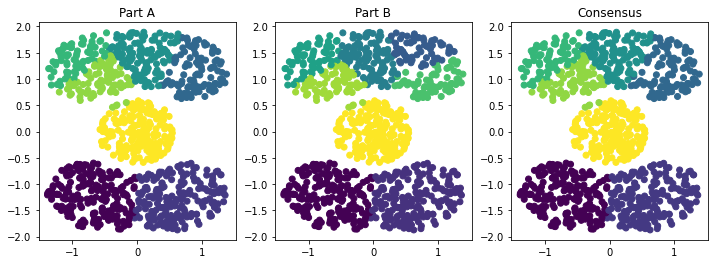

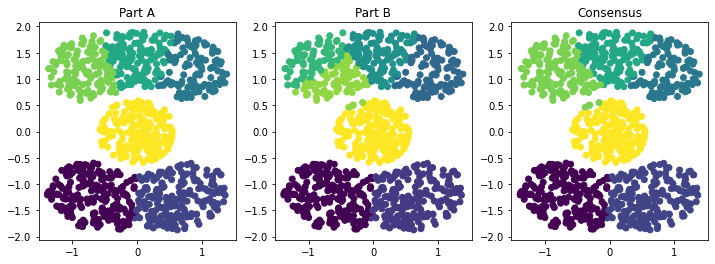

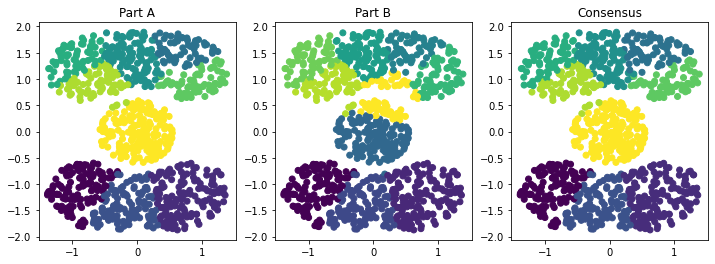

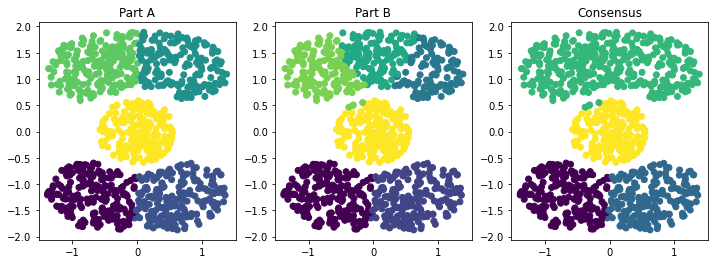

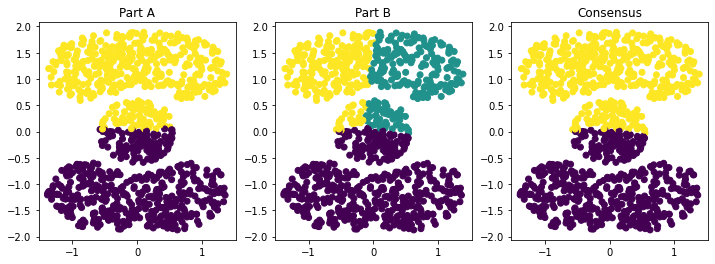

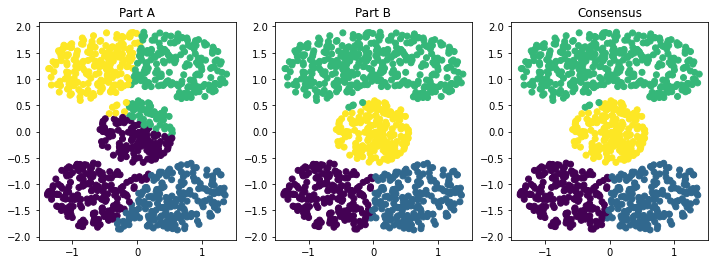

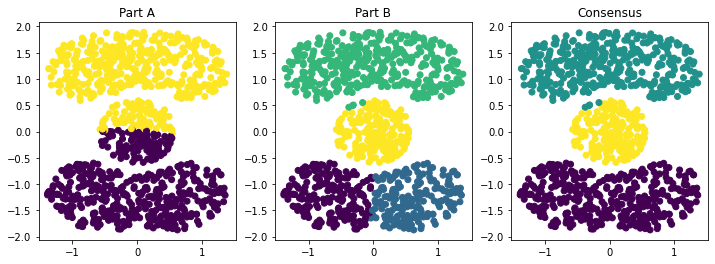

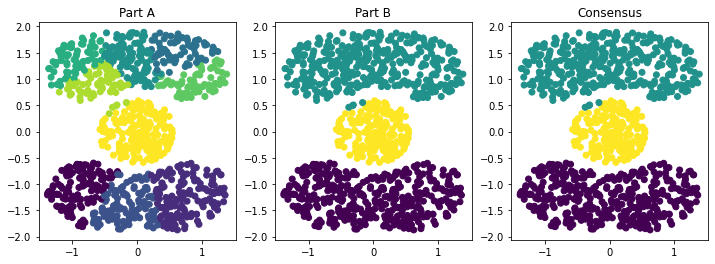

In [16]:
#Generate a consensus using the original function, which implements a global threshold function
(consensus_clusters, consensus_indicator, consensus_map) = modified_consensus(list(partition_list_test), 0.275)

# prints the steps as the consensus function iterates over the input partitions
# output format is partition a, partion b, then the consensus between the two partitions
for x in consensus_map:
    plot_hierarchy_components(x[1][0][0], x[1][1][0], x[0], X.shape[0])
    #plt.close() #uncomment to show graphs of consensus heirarchy

# Analysis of threshold values for heirarchy generated through threshold value of 0.275

Layer 1 done
Layer 2 done
Layer 3 done
Layer 4 done
Layer 5 done
Layer 6 done
Layer 7 done
Layer 8 done


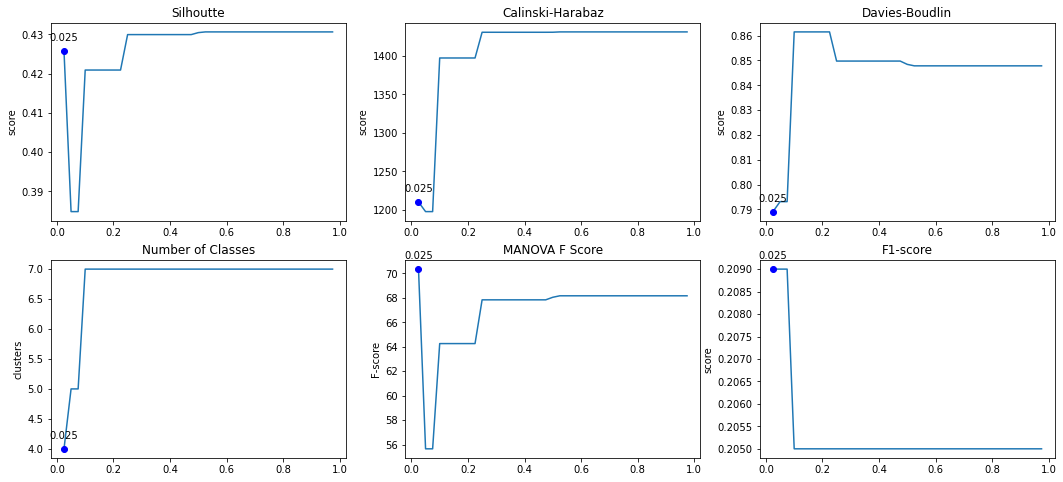

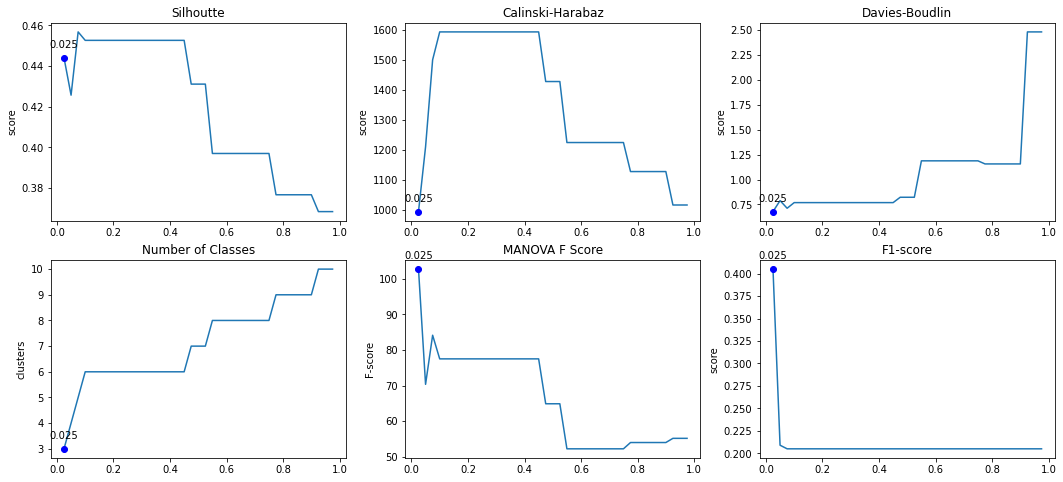

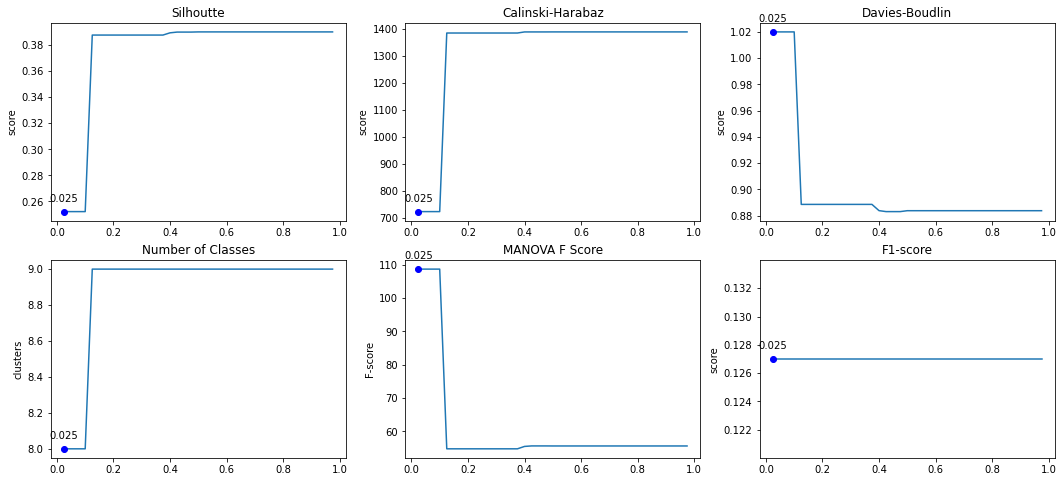

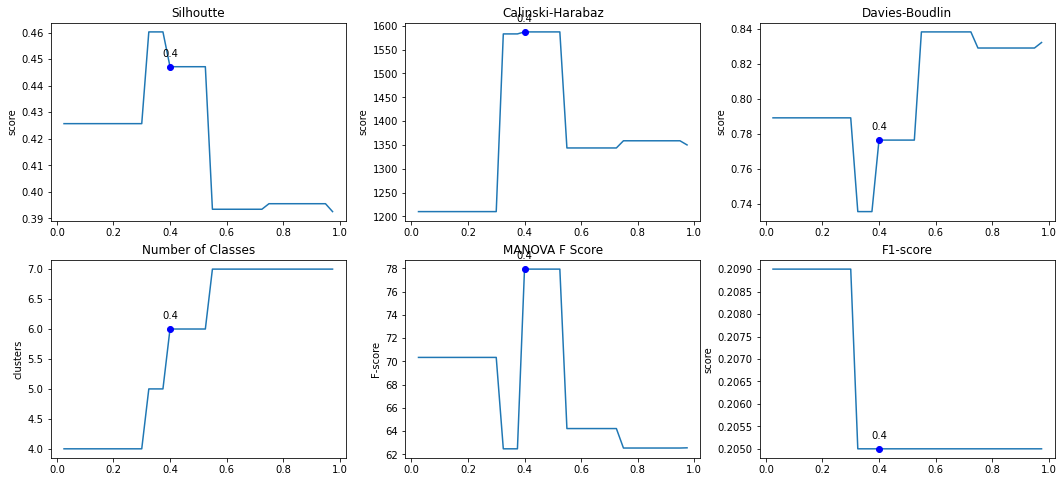

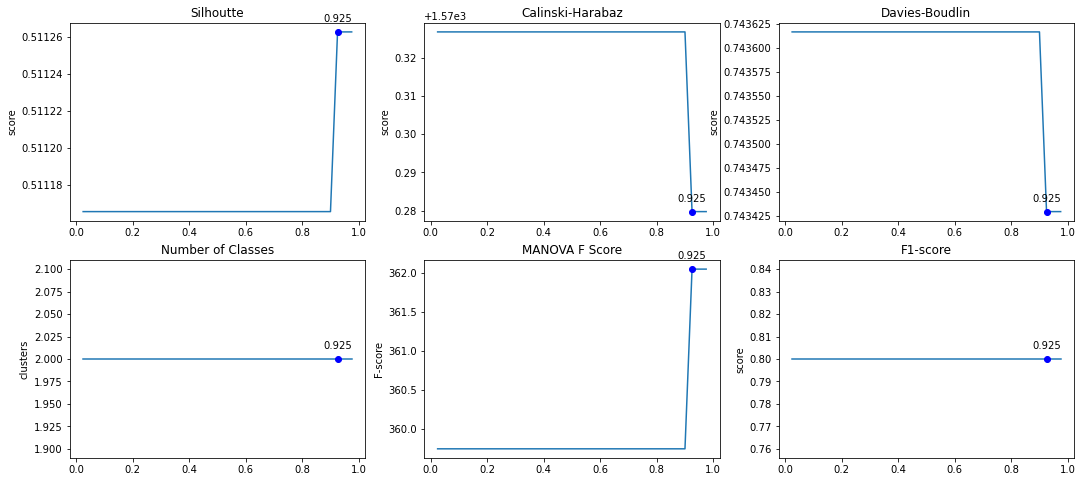

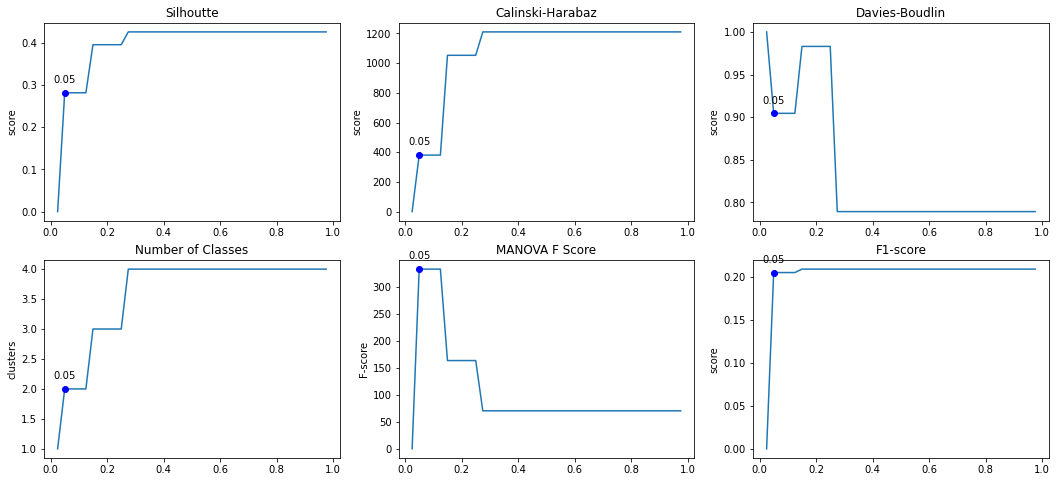

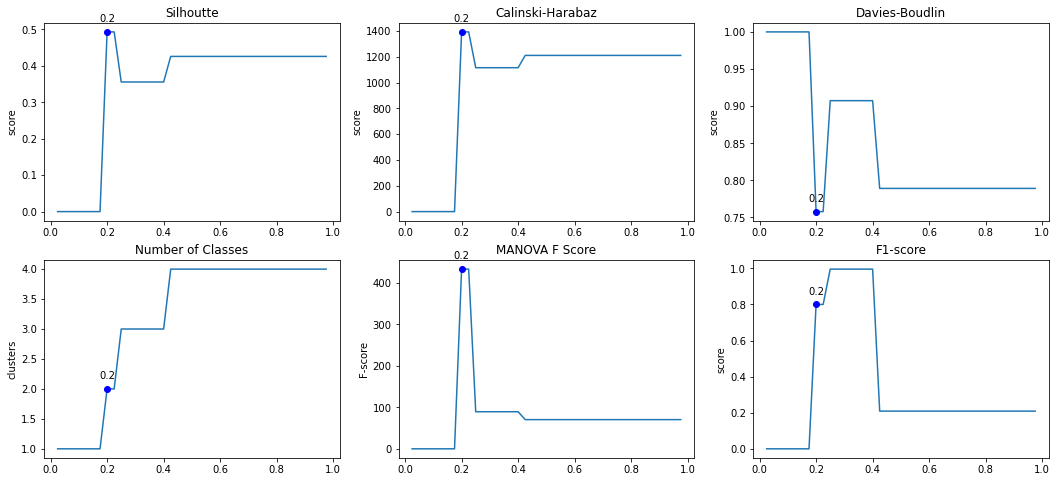

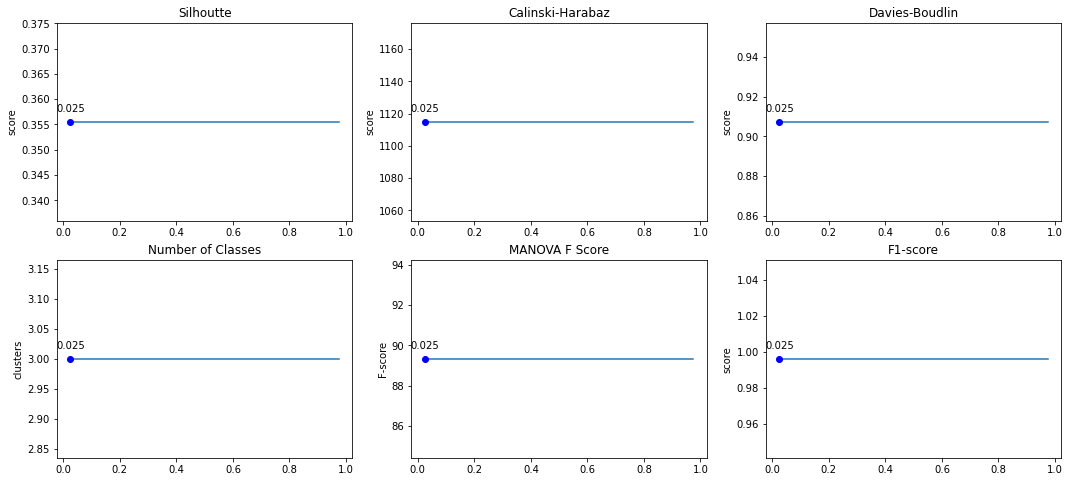

In [15]:
#Generates graphs for all possible threshold values for all measures
thresholds_testing = np.array([])
for i in range(1,40):
    thresholds_testing=np.append(thresholds_testing, (0.025 * i))
    
thresholds_testing=thresholds_testing.round(decimals=3)
    
for i in range(len(consensus_map)):
    #Theortical best value according to maximum manova f-score, an indicator which measures the statistical signifcance of an clustering
    get_best_thresh_for_layer(consensus_map[i][1][0], consensus_map[i][1][1], method=2, supervised=True, truth=y, res=40, plot=True)
    #get_best_thresh_for_layer(consensus_map[i][1][0], consensus_map[i][1][1], res=40, plot=True)
    print("Layer",i+1,"done")
    
#These are plots for the different threshold values for the partitions that were produced when 0.275 is chosen manually

In [16]:
#number of inputs for the consensus is a function of the desired number of classes (ie 2 classes -> 2^2 inputs, 3 classes -> 2^3 inputs)
#this hypothetically minimized the variance in the consensus as the function goes through the heirarchy and increases confidence in the consensus

# Analysis of threshold values for heirarchy generate through dynamic threshold values

Beginning Analysis of ideal threshold values...
Layer 1 -> Threshold: 0.02500 : Number of Clusters 4
Layer 2 -> Threshold: 0.02500 : Number of Clusters 8
Layer 3 -> Threshold: 0.35000 : Number of Clusters 5
Layer 4 -> Threshold: 0.02500 : Number of Clusters 4
Layer 5 -> Threshold: 0.92500 : Number of Clusters 2
Layer 6 -> Threshold: 0.05000 : Number of Clusters 2
Layer 7 -> Threshold: 0.37500 : Number of Clusters 2
Layer 8 -> Threshold: 0.07500 : Number of Clusters 2
Consensus Achieved
Beginning Analysis of ideal global threshold value...
Threshold: 0.225 : Number of Clusters 2
Consensus Achieved
Beginning Analysis of ideal threshold values...
Layer 1 -> Threshold: 0.02500 : Number of Clusters 4
Layer 2 -> Threshold: 0.02500 : Number of Clusters 8
Layer 3 -> Threshold: 0.35000 : Number of Clusters 5
Layer 4 -> Threshold: 0.02500 : Number of Clusters 4
Layer 5 -> Threshold: 0.92500 : Number of Clusters 2
Layer 6 -> Threshold: 0.05000 : Number of Clusters 2
Layer 7 -> Threshold: 0.37500 

Text(0.5, 1.0, 'Variable Global Threshold (Constrained)')

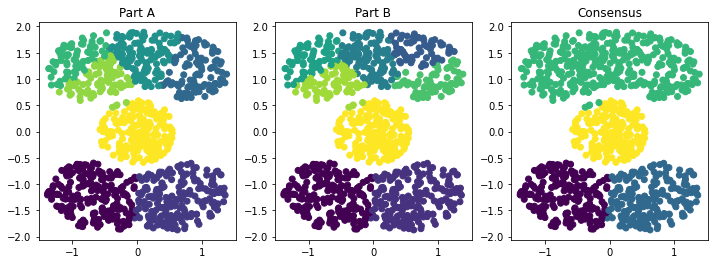

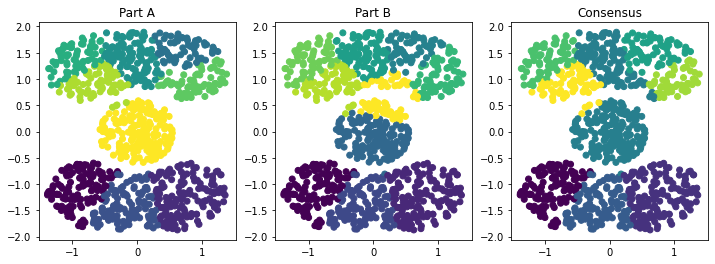

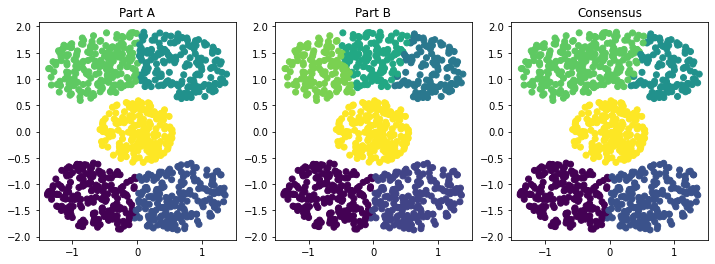

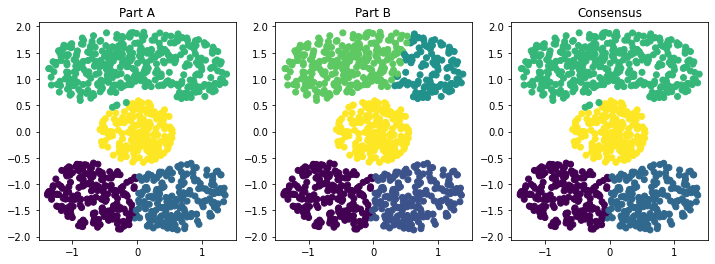

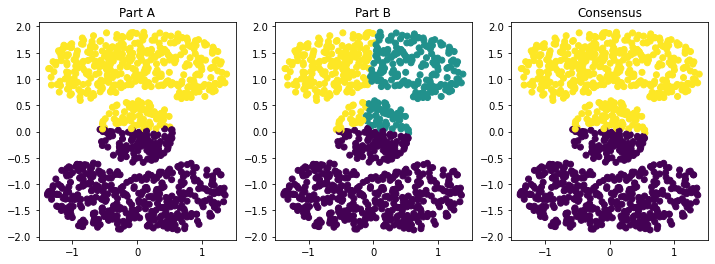

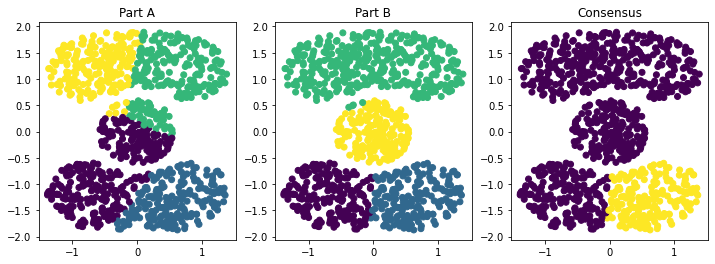

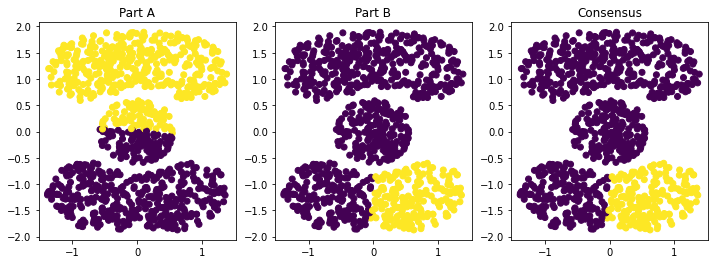

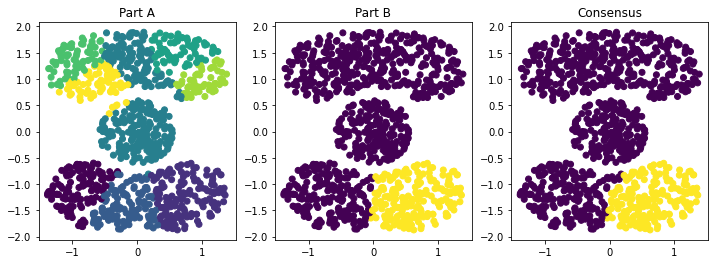

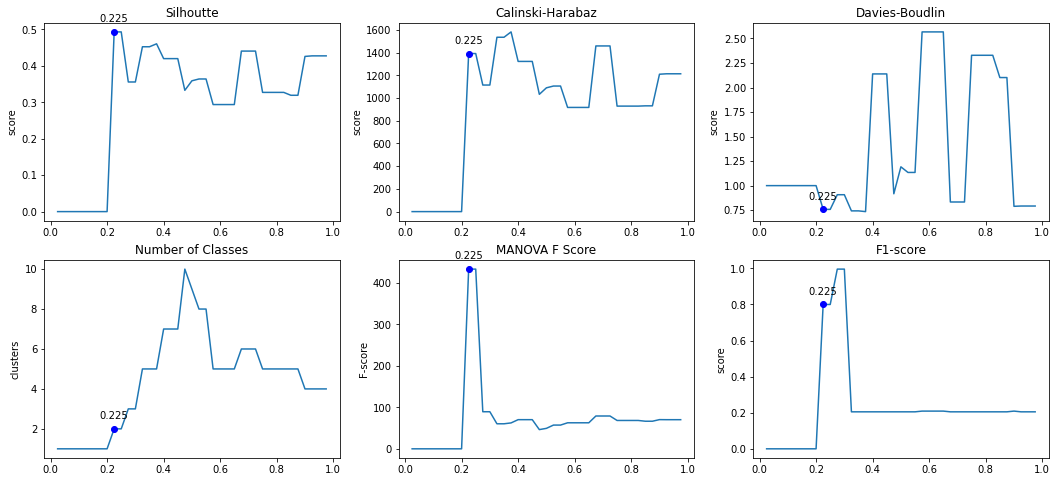

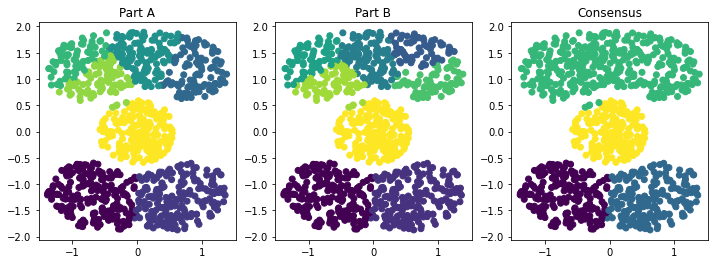

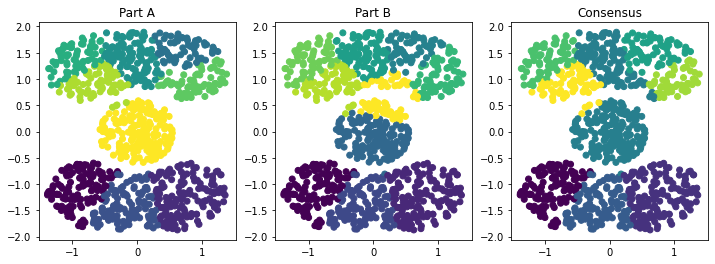

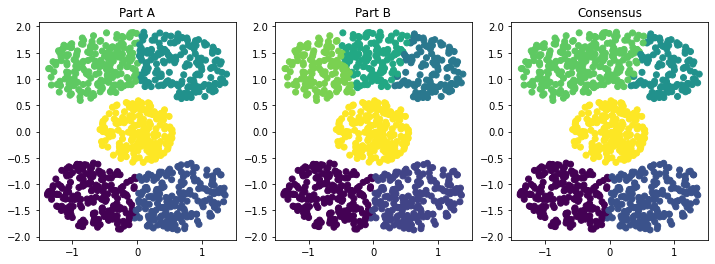

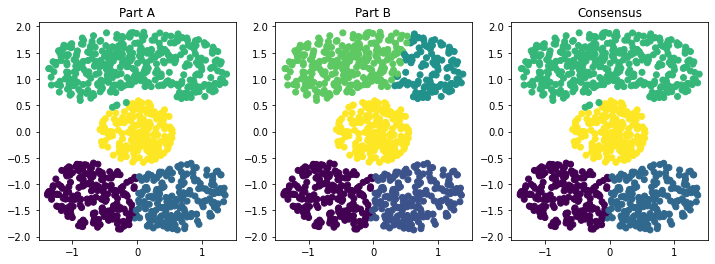

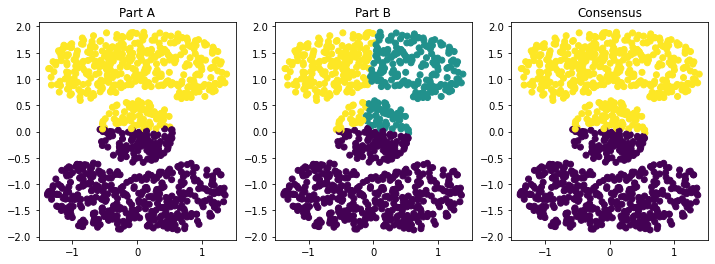

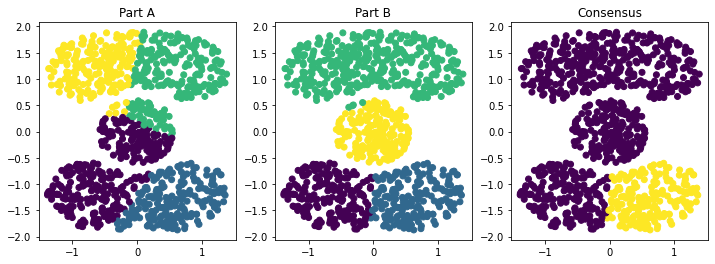

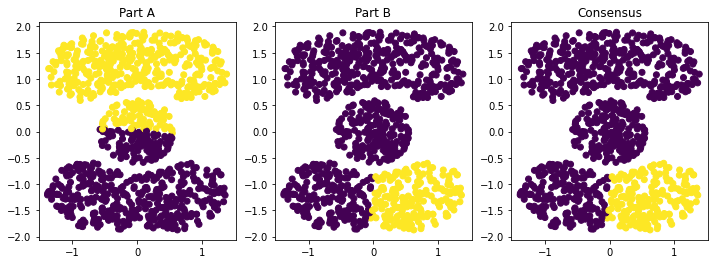

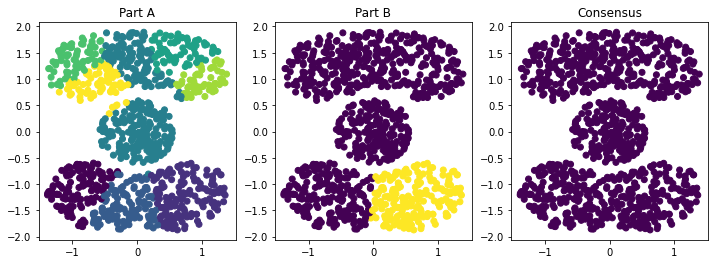

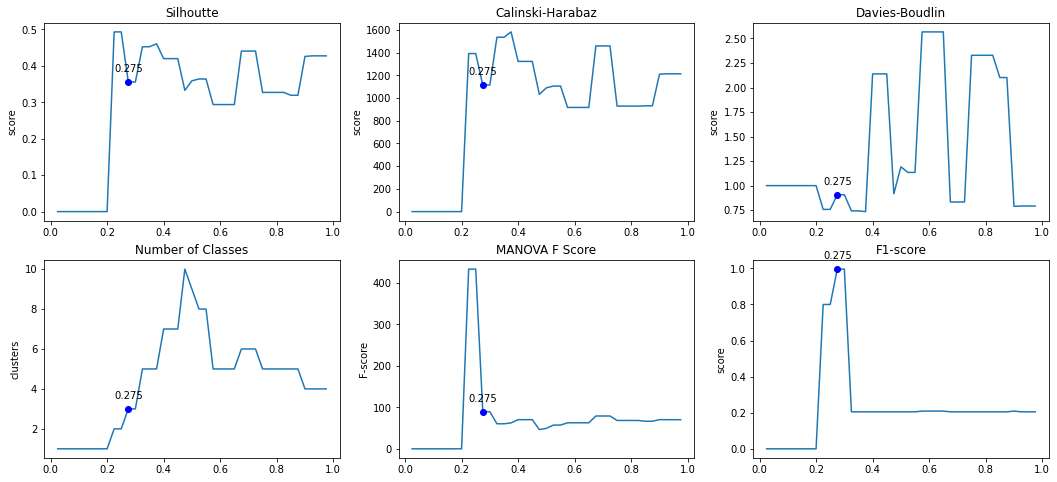

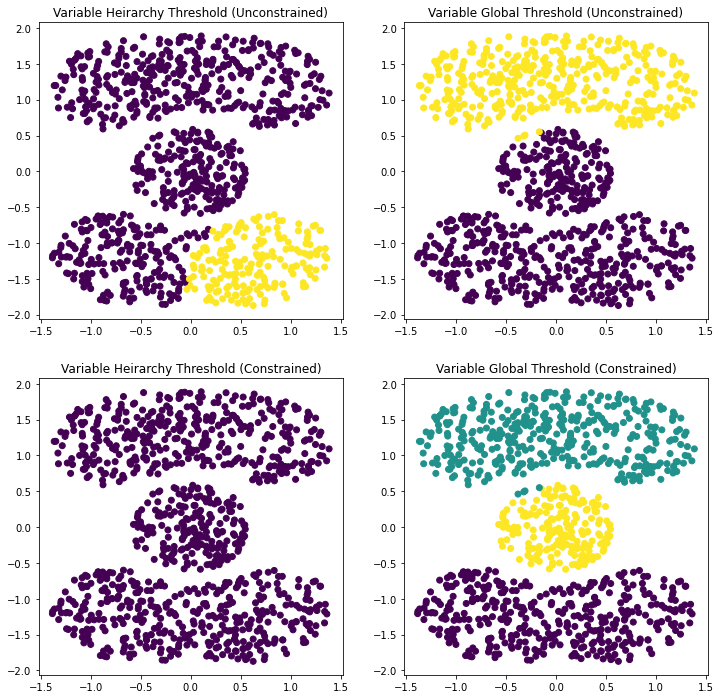

In [17]:
#Consensuses without explicit output constraint
bruh, extra = theoretical_consensus(partition_list_test, method=2, plot_hierarchy=True, supervised=True, truth=y)
bruh = BGC.output_to_array(bruh, X.shape[0])
bruh_2, extra_2 = global_threshold_consensus(partition_list_test, method=2, plot=True, supervised=True, truth=y)
bruh_2 = BGC.output_to_array(bruh_2, X.shape[0])

#Consensuses with explicit output constraint
bruh_3, extra_3 = theoretical_consensus(partition_list_test, method=2, constrain=3, plot_hierarchy=True, supervised=True, truth=y)
bruh_3 = BGC.output_to_array(bruh_3, X.shape[0])
bruh_4, extra_4 = global_threshold_consensus(partition_list_test, method=2, constrain=3, plot=True, supervised=True, truth=y)
bruh_4 = BGC.output_to_array(bruh_4, X.shape[0])

fig_newton = plt.figure(figsize=(12, 12))
cringe = GridSpec(nrows=2, ncols=2)
cool_clust = fig_newton.add_subplot(cringe[0,0])
cool_clust.scatter(X[:,0], X[:,1], c=bruh)
cool_clust.set_title("Variable Heirarchy Threshold (Unconstrained)")
cool_clust_2 = fig_newton.add_subplot(cringe[0,1])
cool_clust_2.scatter(X[:,0], X[:,1], c=bruh_2)
cool_clust_2.set_title("Variable Global Threshold (Unconstrained)")
cool_clust_3 = fig_newton.add_subplot(cringe[1,0])
cool_clust_3.scatter(X[:,0], X[:,1], c=bruh_3)
cool_clust_3.set_title("Variable Heirarchy Threshold (Constrained)")
cool_clust_4 = fig_newton.add_subplot(cringe[1,1])
cool_clust_4.scatter(X[:,0], X[:,1], c=bruh_4)
cool_clust_4.set_title("Variable Global Threshold (Constrained)")

#Order of Output Graphs
#1.) Unconstrained Hierarchy layers
#2.) Unconstrained global 
#3.) Constrained Hierarchy layers
#4.) Constrained global

# MCLA


*****
INFO: Cluster_Ensembles: MCLA: consensus clustering using MCLA.
INFO: Cluster_Ensembles: MCLA: preparing graph for meta-clustering.
INFO: Cluster_Ensembles: MCLA: done filling hypergraph adjacency matrix. Starting computation of Jaccard similarity matrix.
INFO: Cluster_Ensembles: MCLA: starting computation of Jaccard similarity matrix.
INFO: Cluster_Ensembles: MCLA: done computing the matrix of pairwise Jaccard similarity scores.

#
INFO: Cluster_Ensembles: wgraph: writing wgraph_MCLA.
#

#
INFO: Cluster_Ensembles: sgraph: calling gpmetis for graph partitioning.
INFO: Cluster_Ensembles: sgraph: (hyper)-graph partitioning completed; loading wgraph_MCLA.part.10
#
INFO: Cluster_Ensembles: MCLA: delivering 9 clusters.
INFO: Cluster_Ensembles: MCLA: average posterior probability is 0.17633043379701793

*****
INFO: Cluster_Ensembles: MCLA: consensus clustering using MCLA.
INFO: Cluster_Ensembles: MCLA: preparing graph for meta-clustering.
INFO: Cluster_Ensembles: MCLA: done filling hy

Text(0.5, 1.0, 'Consensus With Number Desired')

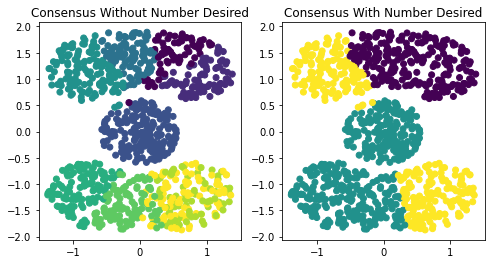

In [5]:
hdf5_file_name = './Cluster_Ensembles.h5'
fileh = tables.open_file(hdf5_file_name, 'w')
fileh.create_group(fileh.root, 'consensus_group')
fileh.close()
hypergraph_adjacency = CE.build_hypergraph_adjacency(mcla_alt)
CE.store_hypergraph_adjacency(hypergraph_adjacency, hdf5_file_name)

hdf5_file_name_2 = './Cluster_Ensembles_2.h5'
fileh_2 = tables.open_file(hdf5_file_name_2, 'w')
fileh_2.create_group(fileh_2.root, 'consensus_group')
fileh_2.close()
hypergraph_adjacency_2 = CE.build_hypergraph_adjacency(mcla_alt)
CE.store_hypergraph_adjacency(hypergraph_adjacency_2, hdf5_file_name_2)

clst = CE.MCLA(hdf5_file_name,mcla_alt)
clst_2= CE.MCLA(hdf5_file_name_2,mcla_alt, N_clusters_max=3)

fig_mcla = plt.figure(figsize=(8, 4))
gs = GridSpec(nrows=1, ncols=2)
ax = fig_mcla.add_subplot(gs[0,0])
ax.scatter(X[:,0], X[:,1], c=clst)
ax.set_title("Consensus Without Number Desired")
ax = fig_mcla.add_subplot(gs[0,1])
ax.scatter(X[:,0], X[:,1], c=clst_2)
ax.set_title("Consensus With Number Desired")